# Transform WAV files to Frequency Domain

In [1]:
import os

import torch
from torch.utils.data import DataLoader
import numpy as np

from src.data import WaveDataset, SpectrogramDataset
from src.features import WaveProcessor, WaveProcessorConfig
from src.visualization import plot_spectrogram, plot_waveform
import matplotlib.pyplot as plt

wdir = os.getcwd().replace("\\", "/") + "/.."
processed_dir = f"{wdir}/data/processed/musicnet"
print(f"Working Directory: {wdir}")
print(f"Processed Directory: {processed_dir}")

Working Directory: D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/..
Processed Directory: D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/processed/musicnet


In [2]:
sr = 44100 // 2

Batch 0: x.shape=torch.Size([2, 1058400]), y.shape=torch.Size([2, 264600])
1727.wav


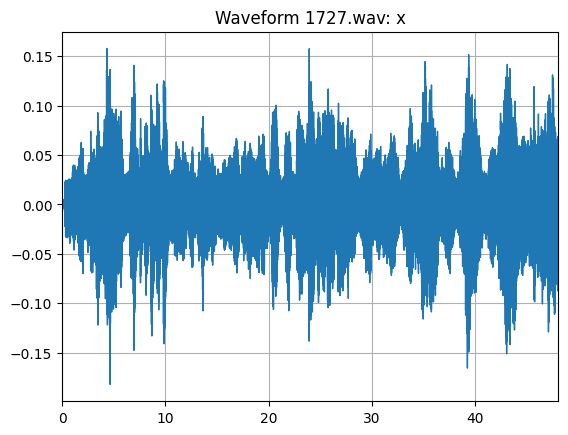

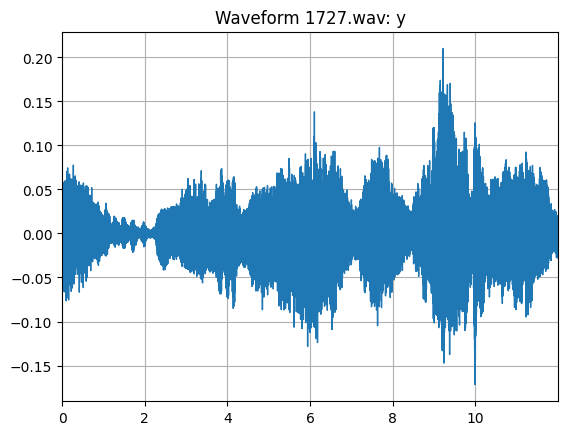

C:\MyApps\anaconda3\envs\csc413\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([128, 5293])
torch.Size([128, 1324])


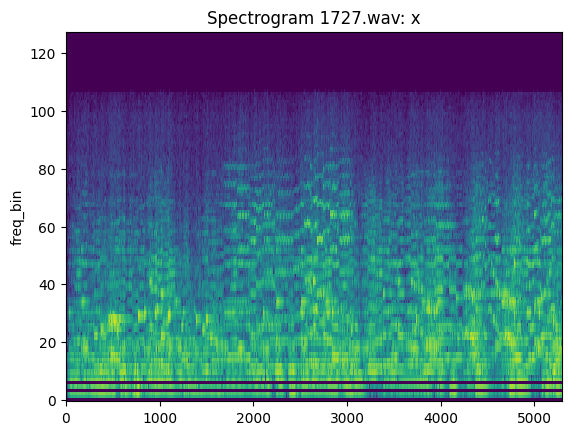

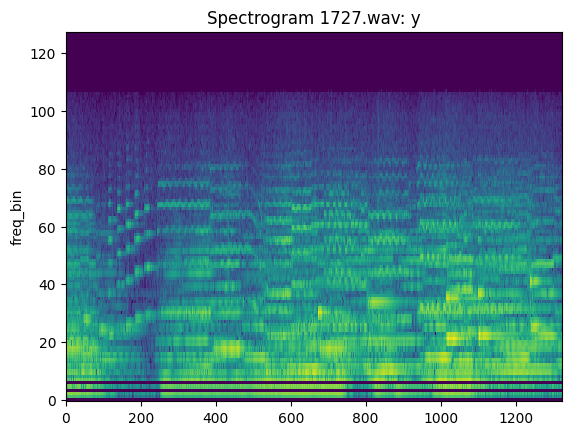

1728.wav


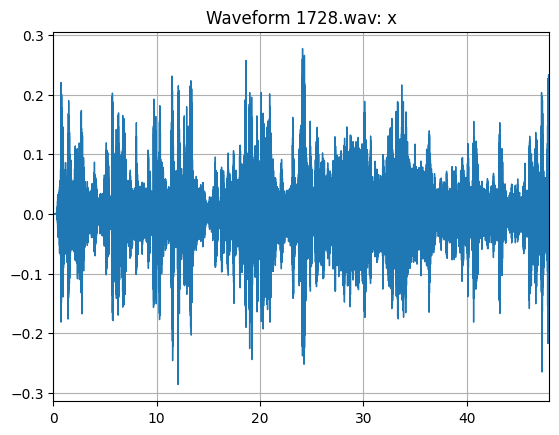

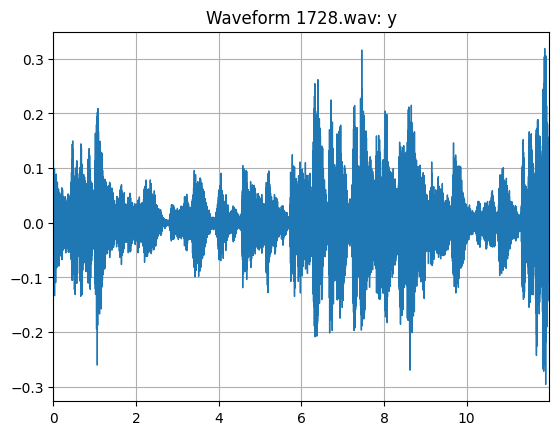

torch.Size([128, 5293])
torch.Size([128, 1324])


C:\MyApps\anaconda3\envs\csc413\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


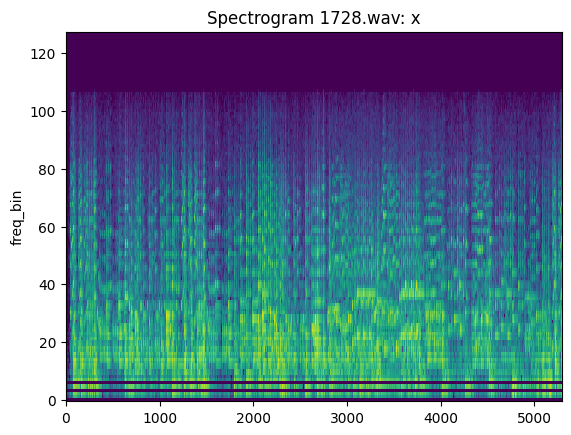

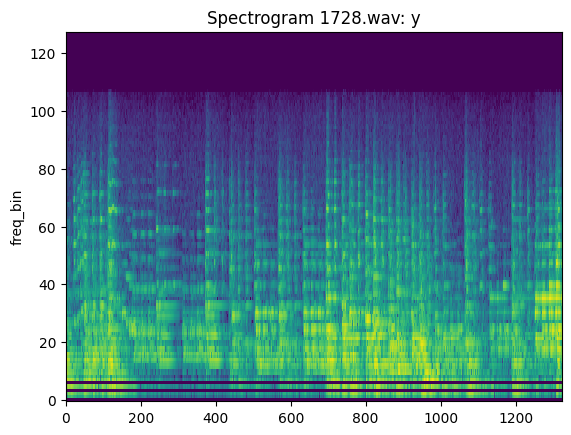

In [3]:
wav_dataset = WaveDataset(f"{wdir}/data/raw/musicnet/train_data", sr=sr)
wpconfig = WaveProcessorConfig(sr=sr)
wp = WaveProcessor(wpconfig)

wav_loader = DataLoader(wav_dataset, batch_size=2, shuffle=False)
for b, (xs, ys, fnames) in enumerate(wav_loader):
    print(f"Batch {b}: x.shape={xs.shape}, y.shape={ys.shape}")
    for x, y, fname in zip(xs, ys, fnames):
        print(f"{fname}")
        if b % 20 == 0:
            plot_waveform(x, sr, title=f"Waveform {fname}: x")
            plot_waveform(y, sr, title=f"Waveform {fname}: y")

        input_spec = wp.wav2freq(x)
        print(input_spec.shape)
        label_spec = wp.wav2freq(y)
        print(label_spec.shape)

        if b % 20 == 0:
            plot_spectrogram(input_spec, title=f"Spectrogram {fname}: x")
            plot_spectrogram(label_spec, title=f"Spectrogram {fname}: y")

        SpectrogramDataset.save(input_spec, f"{processed_dir}/train_data", fname)
        SpectrogramDataset.save(
            label_spec, f"{processed_dir}/train_labels", fname, is_label=True
        )
        SpectrogramDataset.save_metadata(
            wpconfig.to_dict(), f"{processed_dir}/train_meta", fname
        )

    print("====================================")
    if b == 0:
        break

Batch 0
1727.wav.x.npy


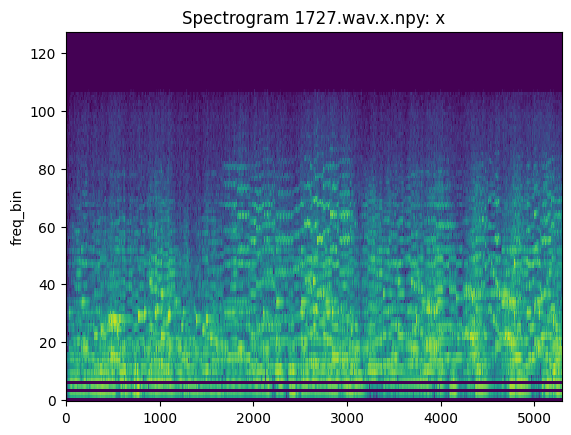

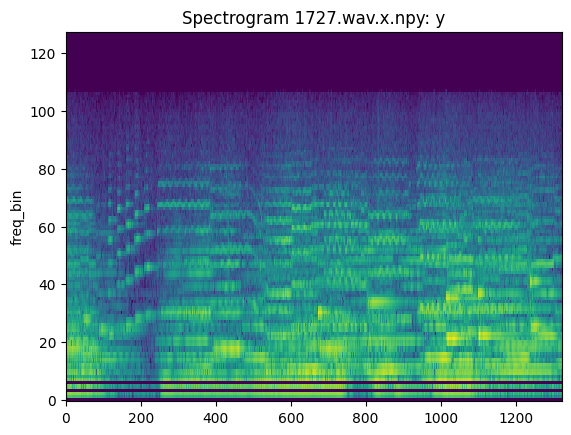

1728.wav.x.npy


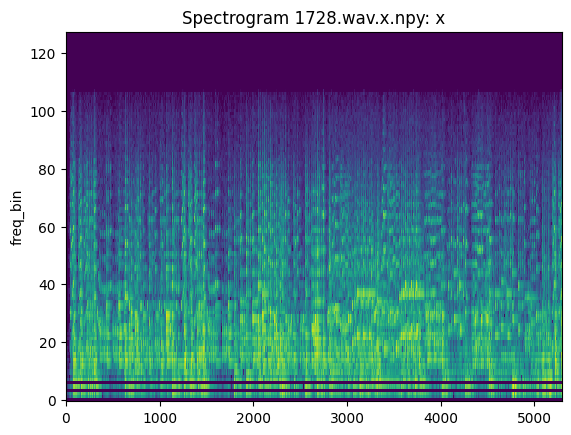

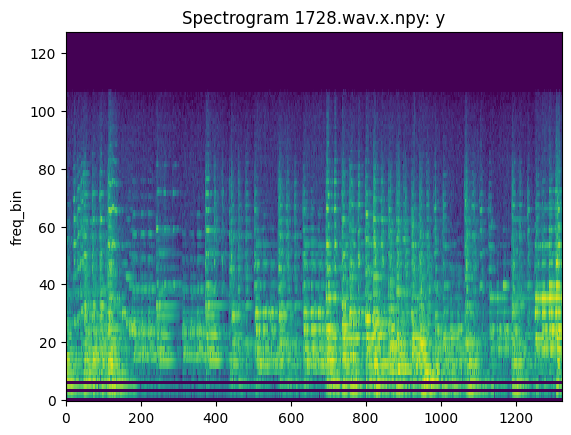

In [4]:
spec_dataset = SpectrogramDataset(
    f"{processed_dir}/train_data", label_dir=f"{processed_dir}/train_labels"
)
spec_loader = DataLoader(spec_dataset, batch_size=2, shuffle=False)

for b, (xs, ys, fnames) in enumerate(spec_loader):
    print(f"Batch {b}")
    for x, y, fname in zip(xs, ys, fnames):
        print(f"{fname}")
        if b % 20 == 0:
            plot_spectrogram(x, title=f"Spectrogram {fname}: x")
            plot_spectrogram(y, title=f"Spectrogram {fname}: y")

    print("====================================")
    if b == 0:
        break